# SBS SMK Test

This notebook should be used as a test for ensuring correct SBS image loading and processing before running a snakemake workflow.
Change the parameters specified at SET PARAMETERS cells and run the notebook to ensure the functions work as intended.

## Imports

In [7]:
from pathlib import Path

from ops.sbs_smk import Snake_sbs

import ops
from ops.imports_ipython import *
from ops.qc import *
import seaborn as sns
from microfilm import microplot
from microfilm.microplot import Micropanel
import matplotlib.pyplot as plt
import matplotlib

### SET PARAMETERS

The following cell contains crucial variables that need to be set according to your specific experimental setup and data organization. Please review and modify these variables as needed before proceeding with the analysis.

- `SBS_CYCLES`: The number and order of SBS cycles
- `WELLS` and `TILES`: The well and tile you want to analyze (for this notebook, we're using one well/tile combination for testing)
- `CHANNELS` and `preprocess_pattern`: The channel names and file naming conventions
- `DF_DESIGN_PATH`: The path to your guide RNA design file
- `DISPLAY_RANGES` and `LUTS`: The display ranges and color schemes (Look-Up Tables) for your image data
- `SEGMENTATION_CYCLE`: Determines which cycle is used for segmentation and illumination correction. Typically, this is set to the cycle with the brightest or clearest signal for cell boundaries, but in the case that we have just taken one multichannel image, it is set to that.
- `DAPI_INDEX`: The index of the DAPI channel in your image stack (0-indexed). Typically 0 for the DAPI channel from sequencing.
- `CYTO_CHANNEL`: The index of the cytoplasmic channel in your image stack (0-indexed). Typically the channel that best outlines cell boundaries, usually base C.
- `NUCLEI_DIAMETER`: Expected cell nuclei diameter. Used by CellPose during segmentation.
- `CELL_DIAMETER`: Expected cell cytoplasm diameter. Used by CellPose during segmentation.
- `CYTO_MODEL`: CellPose cyto model to use during segmentation.
- `THRESHOLD_READS`: The intensity threshold for detecting sequencing reads. Adjust this value based on the signal-to-noise ratio in your data.
- `BASES`: The order of bases used in your sequencing. This should match the order of channels in your sequencing data.
The following cell contains an important parameter for filtering sequencing reads based on their quality. Please review and adjust this variable based on your specific experimental needs before proceeding with the analysis.
- `Q_MIN`: The minimum Levenshtein distance allowed between a read and its closest barcode match. A value of 0 means only perfect matches are accepted, while higher values allow for more mismatches. A lower value increases stringency but may reduce the number of accepted reads, while a higher value allows for more reads but may increase false positives.

Ensure these variables accurately reflect your experimental setup to guarantee correct data processing and analysis.

In [8]:
# Define lists of cycles
SBS_CYCLES = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
CYCLE_FILES = None

# Set wells and tiles (in this notebook, one well / tile combination to test on)
WELLS = 'A1' 
TILES = 50
WILDCARDS = dict(well=WELLS, tile=TILES)

# Define channels
CHANNELS = None

# Define the file pattern
INPUT_FILES_DIR = "../example_data/sbs/input/tile_based_tifs/"
PREPROCESS_PATTERN = '10X_c{cycle}-SBS-{cycle}_{well}_Tile-{tile}.sbs.tif'

# Read and format guide data
DF_DESIGN_PATH = "../example_data/sbs/input/pool10_design.csv"
df_design = pd.read_csv(DF_DESIGN_PATH)
df_pool = df_design.query('dialout==[0,1]').drop_duplicates('sgRNA')
df_pool['prefix'] = df_pool.apply(lambda x: x.sgRNA[:x.prefix_length], axis=1) # 13
barcodes = df_pool['prefix']

# Define display ranges for different channels, recognized by ImageJ
DISPLAY_RANGES = [
    [500, 15000],  # Range for DAPI channel
    [100, 10000],  # Range for CY3 channel
    [100, 10000],  # Range for A594 channel
    [200, 25000],  # Range for CY5 channel
    [200, 25000]   # Range for CY7 channel
]

# Define LUTs (Lookup Tables) for different channels
LUTS = [
    ops.io.GRAY,    # Lookup table for DAPI channel
    ops.io.GREEN,   # Lookup table for CY3 channel
    ops.io.RED,     # Lookup table for A594 channel
    ops.io.MAGENTA, # Lookup table for CY5 channel
    ops.io.CYAN     # Lookup table for CY7 channel
]

# Define segmentation cycle
SEGMENTATION_CYCLE = -1

# Define Cellpose segmentation parameters
DAPI_INDEX = 0
CYTO_CHANNEL = 4

# Parameters for cellpose method
NUCLEI_DIAMETER = 13.2  # Calibrate with CellPose
CELL_DIAMETER = 19.5    # Calibrate with CellPose
CYTO_MODEL = "cyto3"

# Define parameters for extracting bases
THRESHOLD_READS = 315
BASES = 'GTAC'

# Define parameters for read mapping
Q_MIN = 0

# Output directory for notebook results
OUTPUT_FILES_DIR = "../example_data/sbs/output/tile_based_test_nb/"

In [9]:
## load files

# Function to generate file paths
def generate_file_paths(input_files_dir, preprocess_pattern, well, tile, sbs_cycles):
    file_paths = []
    
    # All cycles (all channels)
    for cycle in sbs_cycles:
        cycle_file_name = preprocess_pattern.format(cycle=cycle, well=well, tile=tile)
        cycle_file_path = f"{input_files_dir}{cycle_file_name}"
        file_paths.append(cycle_file_path)
    
    return file_paths

# Custom function to create segmentation colormap
def random_cmap(alpha=0.5, num_colors=256):
    """Create random colormap for segmentation"""
    colmat = np.random.rand(num_colors,4)
    colmat[:,-1] = alpha
    colmat[0, :] = [0, 0, 0, 1]  # Set the first color to black with full transparency
    cmap = matplotlib.colors.ListedColormap(colmat)
    return cmap

input_image_paths = generate_file_paths(INPUT_FILES_DIR, PREPROCESS_PATTERN, WELLS, TILES, SBS_CYCLES)

# Print the files
for f in input_image_paths:
    print(f)
    
# manually change saving directory to sbs_1 directory
description = parse(input_image_paths[0])
description.pop('cycle')
description.pop('tag')
description

../example_data/sbs/input/tile_based_tifs/10X_c1-SBS-1_A1_Tile-50.sbs.tif
../example_data/sbs/input/tile_based_tifs/10X_c2-SBS-2_A1_Tile-50.sbs.tif
../example_data/sbs/input/tile_based_tifs/10X_c3-SBS-3_A1_Tile-50.sbs.tif
../example_data/sbs/input/tile_based_tifs/10X_c4-SBS-4_A1_Tile-50.sbs.tif
../example_data/sbs/input/tile_based_tifs/10X_c5-SBS-5_A1_Tile-50.sbs.tif
../example_data/sbs/input/tile_based_tifs/10X_c6-SBS-6_A1_Tile-50.sbs.tif
../example_data/sbs/input/tile_based_tifs/10X_c7-SBS-7_A1_Tile-50.sbs.tif
../example_data/sbs/input/tile_based_tifs/10X_c8-SBS-8_A1_Tile-50.sbs.tif
../example_data/sbs/input/tile_based_tifs/10X_c9-SBS-9_A1_Tile-50.sbs.tif
../example_data/sbs/input/tile_based_tifs/10X_c10-SBS-10_A1_Tile-50.sbs.tif
../example_data/sbs/input/tile_based_tifs/10X_c11-SBS-11_A1_Tile-50.sbs.tif


{'subdir': '../example_data/sbs/input/tile_based_tifs',
 'mag': '10X',
 'well': 'A1',
 'tile': '50',
 'ext': 'tif',
 'file': '../example_data/sbs/input/tile_based_tifs/10X_c1-SBS-1_A1_Tile-50.sbs.tif'}

In [10]:
input_images = [read(f) for f in input_image_paths]
print(len(input_images))

11


In [11]:
# This corresponds to the 'align' rule in Snakemake
aligned = Snake_sbs._align_SBS(input_images, method='SBS_mean', cycle_files=CYCLE_FILES, upsample_factor = 1, n = 1, keep_extras=False)
print(aligned.shape) # expected dimensions of (CYCLE, CHANNEL, I, J)
save(name(description, tag='aligned', subdir=OUTPUT_FILES_DIR), aligned, display_ranges=DISPLAY_RANGES, luts=LUTS) # play around with display ranges

(11, 5, 1200, 1200)


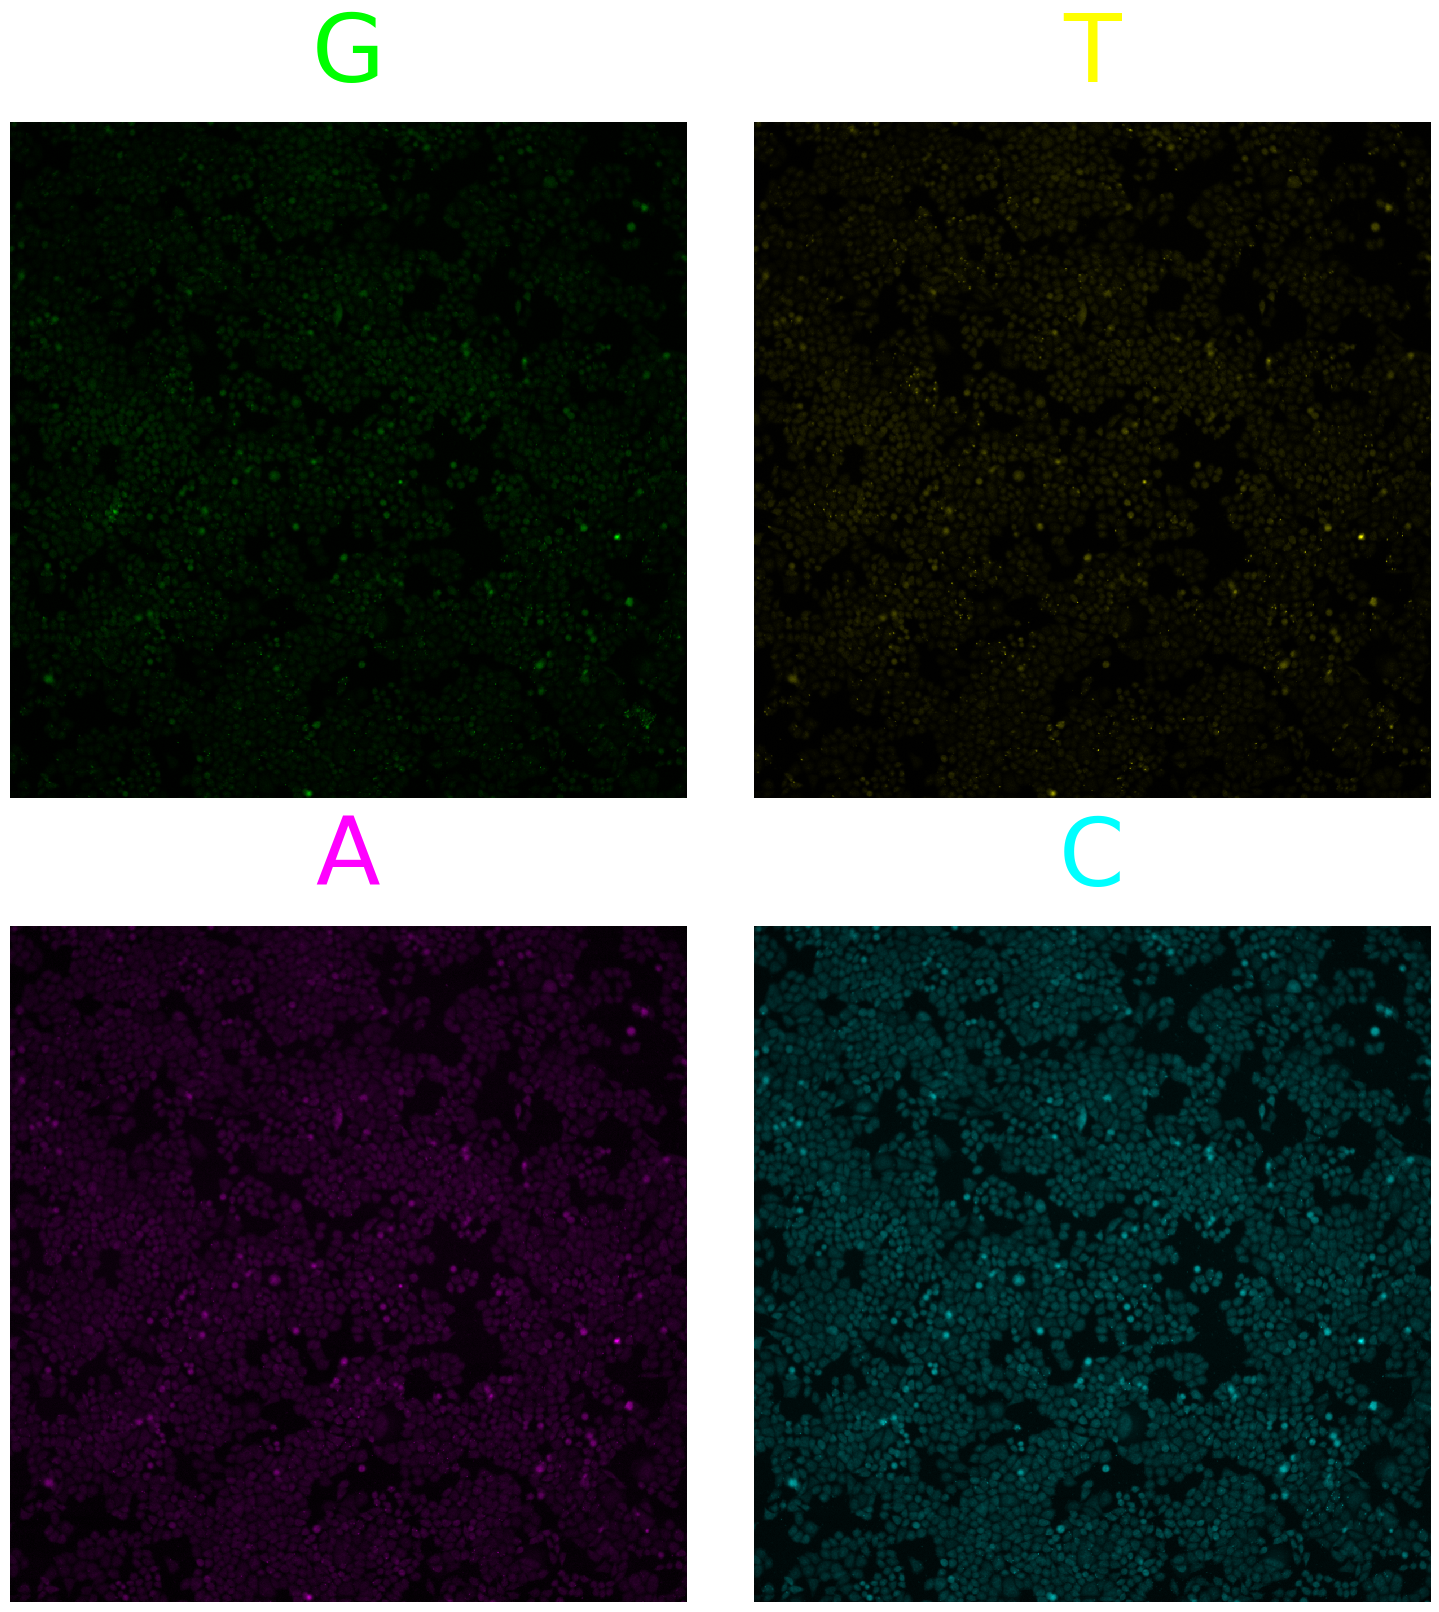

In [12]:
# show aligned for one round
g_aligned_microshow = microplot.Microimage(aligned[0,1,:,:],
                                           cmaps = 'pure_green',
                                           channel_names='G')
t_aligned_microshow = microplot.Microimage(aligned[0,2,:,:],
                                           cmaps = 'pure_yellow',
                                           channel_names='T')
a_aligned_microshow = microplot.Microimage(aligned[0,3,:,:],
                                           cmaps = 'pure_magenta',
                                           channel_names='A')
c_aligned_microshow = microplot.Microimage(aligned[0,4,:,:],
                                           cmaps = 'pure_cyan',
                                           channel_names='C')
panel = Micropanel(rows=2, cols=2, figscaling=8)
panel.add_element([0,0], g_aligned_microshow)
panel.add_element([0,1], t_aligned_microshow)
panel.add_element([1,0], a_aligned_microshow)
panel.add_element([1,1], c_aligned_microshow)
panel.add_channel_label()